<a href="https://colab.research.google.com/github/rahiakela/deep-learning--from-basics-to-practice/blob/23-keras-part-1/3_training_the_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training The Model

## Setup

In [0]:
from keras.datasets import mnist
from keras import backend as Keras_backend
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt

import numpy as np

from keras import backend as keras_backend
keras_backend.set_image_data_format('channels_last')

Using TensorFlow backend.


In [0]:
from keras.datasets import mnist
from keras import backend as keras_backend

# load MNIST data and save sizes
(X_train, y_train), (X_test, y_test) = mnist.load_data()

image_height = X_train.shape[1]
print(f'image_height = {image_height}')
image_width = X_train.shape[2]
print(f'image_width = {image_width}')
number_of_pixels = image_height * image_width
print(f'number_of_pixels = {number_of_pixels}')
print()

# convert to floating-point
X_train = keras_backend.cast_to_floatx(X_train)
X_test = keras_backend.cast_to_floatx(X_test)
print(f'Before scalling: \n {X_train[:1]}')
print()

# scale data to range [0, 1]
X_train /= 255.0
X_test /= 255.0
print(f'After scalling: \n {X_train[:1]}')
print()

# save the original y_train and y_test
original_y_train = y_train
original_y_test = y_test

# replace label data with one-hot encoded versions
number_of_classes = 1 + max(np.append(y_train, y_test)).astype(np.int32)
print(f'number_of_classes: {number_of_classes}')

# encode each list into one-hot arrays of the size we just found
y_train = to_categorical(y_train, num_classes=number_of_classes)
y_test = to_categorical(y_test, num_classes=number_of_classes)

# reshape samples to 2D grid, one line per image
X_train = X_train.reshape([X_train.shape[0], number_of_pixels])
X_test = X_test.reshape([X_test.shape[0], number_of_pixels])

In [0]:
from keras.models import Sequential
from keras.layers import Dense

def make_one_hidden_layer_model():

  # create an empty model
  model = Sequential()

  # add a fully-connected hidden layer with #nodes = #pixels
  model.add(Dense(number_of_pixels, activation='relu', input_shape=[number_of_pixels]))

  # add an output layer with softmax activation
  model.add(Dense(number_of_classes, activation='softmax'))

  # compile the model to turn it from specification to code
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  return model

# make the model
model = make_one_hidden_layer_model()  
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 784)               615440    
_________________________________________________________________
dense_6 (Dense)              (None, 10)                7850      
Total params: 623,290
Trainable params: 623,290
Non-trainable params: 0
_________________________________________________________________


## Motivation

Now that our data is set up for learning, and we have a model defined
and compiled, it’s time to give the data to the model and let it learn.

This is where a library like Keras really shines. All the machine-learning
work of managing the data flow, calculating gradients with backprop,
applying weight update formulas, and the rest, is all handled for us.

To keep an eye on the learning process, we can ask fit() to print out
intermediate progress after each epoch. This lets us see if things are
going well, and potentially interrupt the process if the network isn’t
learning. If we do let it run to completion, fit() returns an object of
type History. This contains all the data that Keras measured after each
epoch, such as the model’s accuracy and loss. We can use that history
to make plots and graphs to visualize the system’s performance.

The training data is now simply called x and y, though since they’re the
first two arguments we don’t have to explicitly provide those names.
The data that’s then used to evaluate the system is called the validation
data, not the test data. The reason for this is that Keras will
evaluate our model after each epoch. Thus we hold the test data aside,
to evaluate the final model just before deployment. We use the validation
set for measuring performance while training.

The first two arguments, which are both mandatory, are the training
samples and the training labels, in that order. As we just saw, they’re
called x and y, though following Python convention, these mandatory
first arguments are usually not explicitly named when we call fit().

During training, fit() will periodically evaluate the model using the
validation data. We can choose to either provide that data explicitly, or
we can tell fit() to extract a validation set from the input data.

If we have our own validation data (as we do with MNIST), we provide
the validation samples and their labels in a little 2-element list as the
value of the optional argument validation_data.

If we don’t have our own validation set, fit() can make one for us if
we give it a value for the argument validation_split, in the form of
a floating-point number from 0 to 1, telling it what percentage of the
training data to use as validation data. This is like using scikit-learn’s
train_test_split() routine, but on the fly. Generally speaking, it’s
better to provide our own validation data, since we have more control
over what it contains.

we typically train models in mini-batches.
Since we rarely train with the full batch at one time, many people refer
to mini-batches as simply “batches.” Keras does this as well, using
parameter names like batch_size for what is more properly a “minibatch
size.” Since using “batch” for “mini-batch” is so common, we’ll
use that language here as well.

When learning in batches, fit() will pull off a batch-sized chunk of
samples from our training set, learn from it, update the weights, and
then take another chunk. It’s our job to tell fit() how big those
chunks should be with the optional argument batch_size. This argument
defaults to 32, but we can set it to any value we like. If we’re
using a GPU, we typically set this to a power of 2 (like 32 or 128) that
makes our data fit best into the GPU we’re using, so it can process an
entire batch in one parallelized operation. When we’re training on a
CPU only, we often use a larger batch size, perhaps even a few hundred
samples, since our computer has more memory available.

Another important argument is how many epochs the training should
run for. Recall that one epoch means one complete pass through the
training set.

The last argument we’ll use is verbose, which tells the system how
chatty to be after each epoch (grammatically, we might prefer “verbosity”
for the name of this argument, but verbose it is). If we set this to 0
it doesn’t print out anything. A value of 1 prints an animated progress bar that shows the system chugging its way through the samples in
each epoch. A value of 2 just shows a single summary line of text after
each epoch.

Let’s train our model with our own validation data, for 3 epochs. Since
we’re training on a CPU, we’ll use a large batch size of 256 samples per
batch. This will give us smoother graphs when we plot our data, compared
to the results for the smaller batch sizes we’d usually use if we
were training on a GPU. We’ll set verbose to 2 so that we’ll get a line
of information after each epoch.

In [0]:
# call fit() to train the model, and save the history
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, batch_size=256, verbose=2)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 60000 samples, validate on 10000 samples
Epoch 1/3





 - 6s - loss: 0.3000 - acc: 0.9159 - val_loss: 0.1482 - val_acc: 0.9574
Epoch 2/3
 - 5s - loss: 0.1219 - acc: 0.9648 - val_loss: 0.1009 - val_acc: 0.9707
Epoch 3/3
 - 6s - loss: 0.0797 - acc: 0.9771 - val_loss: 0.0830 - val_acc: 0.9741


## Training A Model

In [0]:
from keras.datasets import mnist
from keras import backend as keras_backend
from keras.models import Sequential
from keras.layers import Dense

# load MNIST data and save sizes
(X_train, y_train), (X_test, y_test) = mnist.load_data()

image_height = X_train.shape[1]
image_width = X_train.shape[2]
number_of_pixels = image_height * image_width


# convert to floating-point
X_train = keras_backend.cast_to_floatx(X_train)
X_test = keras_backend.cast_to_floatx(X_test)


# scale data to range [0, 1]
X_train /= 255.0
X_test /= 255.0


# save the original y_train and y_test
original_y_train = y_train
original_y_test = y_test

# replace label data with one-hot encoded versions
number_of_classes = 1 + max(np.append(y_train, y_test)).astype(np.int32)

# encode each list into one-hot arrays of the size we just found
y_train = to_categorical(y_train, num_classes=number_of_classes)
y_test = to_categorical(y_test, num_classes=number_of_classes)

# reshape samples to 2D grid, one line per image
X_train = X_train.reshape([X_train.shape[0], number_of_pixels])
X_test = X_test.reshape([X_test.shape[0], number_of_pixels])

def make_one_hidden_layer_model():

  # create an empty model
  model = Sequential()

  # add a fully-connected hidden layer with #nodes = #pixels
  model.add(Dense(number_of_pixels, activation='relu', input_shape=[number_of_pixels]))

  # add an output layer with softmax activation
  model.add(Dense(number_of_classes, activation='softmax'))

  # compile the model to turn it from specification to code
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  return model

# make the model
one_hidden_layer_model = make_one_hidden_layer_model()  
one_hidden_layer_model.summary()

# call fit() to train the model, and save the history
history = one_hidden_layer_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, batch_size=256, verbose=2)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 784)               615440    
_________________________________________________________________
dense_8 (Dense)              (None, 10)                7850      
Total params: 623,290
Trainable params: 623,290
Non-trainable params: 0
_________________________________________________________________
Train on 60000 samples, validate on 10000 samples
Epoch 1/3
 - 6s - loss: 0.3055 - acc: 0.9153 - val_loss: 0.1513 - val_acc: 0.9540
Epoch 2/3
 - 6s - loss: 0.1224 - acc: 0.9649 - val_loss: 0.0977 - val_acc: 0.9701
Epoch 3/3
 - 6s - loss: 0.0806 - acc: 0.9766 - val_loss: 0.0834 - val_acc: 0.9733


The validation data also looks good. Again, the loss is dropping every
epoch, and the accuracy is climbing. After just 3 epochs of training, it’s
already up to over 97% accuracy! That’s not nearly as good as the best
scores anyone’s found.

But it’s pretty amazing that with a tiny network containing just one hidden layer, after only 3 epochs of
learning, and no tuning at all, we are recognizing handwritten digits
correctly 97.5% of the time!

Training for 3 epochs isn’t really enough for almost any network, even
one this simple. Let’s run this for 20 epochs and see how it does. All
we have to do is change the argument to epochs to 20 and let it go.

In [14]:
one_hidden_layer_history = one_hidden_layer_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=256, verbose=2)

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
 - 5s - loss: 0.0133 - acc: 0.9954 - val_loss: 0.0701 - val_acc: 0.9821
Epoch 2/20
 - 5s - loss: 0.0030 - acc: 0.9993 - val_loss: 0.0657 - val_acc: 0.9828
Epoch 3/20
 - 5s - loss: 9.5026e-04 - acc: 0.9999 - val_loss: 0.0615 - val_acc: 0.9841
Epoch 4/20
 - 5s - loss: 4.6822e-04 - acc: 1.0000 - val_loss: 0.0629 - val_acc: 0.9838
Epoch 5/20
 - 5s - loss: 3.7288e-04 - acc: 1.0000 - val_loss: 0.0627 - val_acc: 0.9845
Epoch 6/20
 - 5s - loss: 3.1258e-04 - acc: 1.0000 - val_loss: 0.0644 - val_acc: 0.9840
Epoch 7/20
 - 5s - loss: 2.7448e-04 - acc: 1.0000 - val_loss: 0.0644 - val_acc: 0.9844
Epoch 8/20
 - 5s - loss: 2.3795e-04 - acc: 1.0000 - val_loss: 0.0656 - val_acc: 0.9841
Epoch 9/20
 - 5s - loss: 2.1369e-04 - acc: 1.0000 - val_loss: 0.0659 - val_acc: 0.9842
Epoch 10/20
 - 5s - loss: 1.9100e-04 - acc: 1.0000 - val_loss: 0.0668 - val_acc: 0.9838
Epoch 11/20
 - 5s - loss: 1.6975e-04 - acc: 1.0000 - val_loss: 0.0677 - val_acc: 0.9842

Our score on the training set is 100% accuracy. That’s perfection!

The testing set score is not perfect, but it’s very respectable for such a
simple model. Our model is misclassifying only 157 out of all 10,000
test samples.

In [0]:
# build the error grid. each [y][x] is a list of all test images
# with label y, but were mis-categorized as x
predictions = one_hidden_layer_model.predict_classes(X_test, verbose=0)

error_grid = [[[] for x in range(10)] for y in range(10)]
matchList = predictions == original_y_test
errorCount = 0
for i in range(matchList.size):
  if matchList[i] != True:
    error_grid[original_y_test[i]][predictions[i]].append(i)

In [16]:
# how many did we get right?
pred_right = np.sum(matchList)
pred_wrong = len(original_y_test) - pred_right
print(f'Correct predictions = {pred_right} out of {len(original_y_test)}')
print(f'Incorrect predictions = {pred_wrong}')

Correct predictions = 9843 out of 10000
Incorrect predictions = 157


One of the nice things about using image
data is that we can look at it. Let’s look at some examples that were
misclassified.

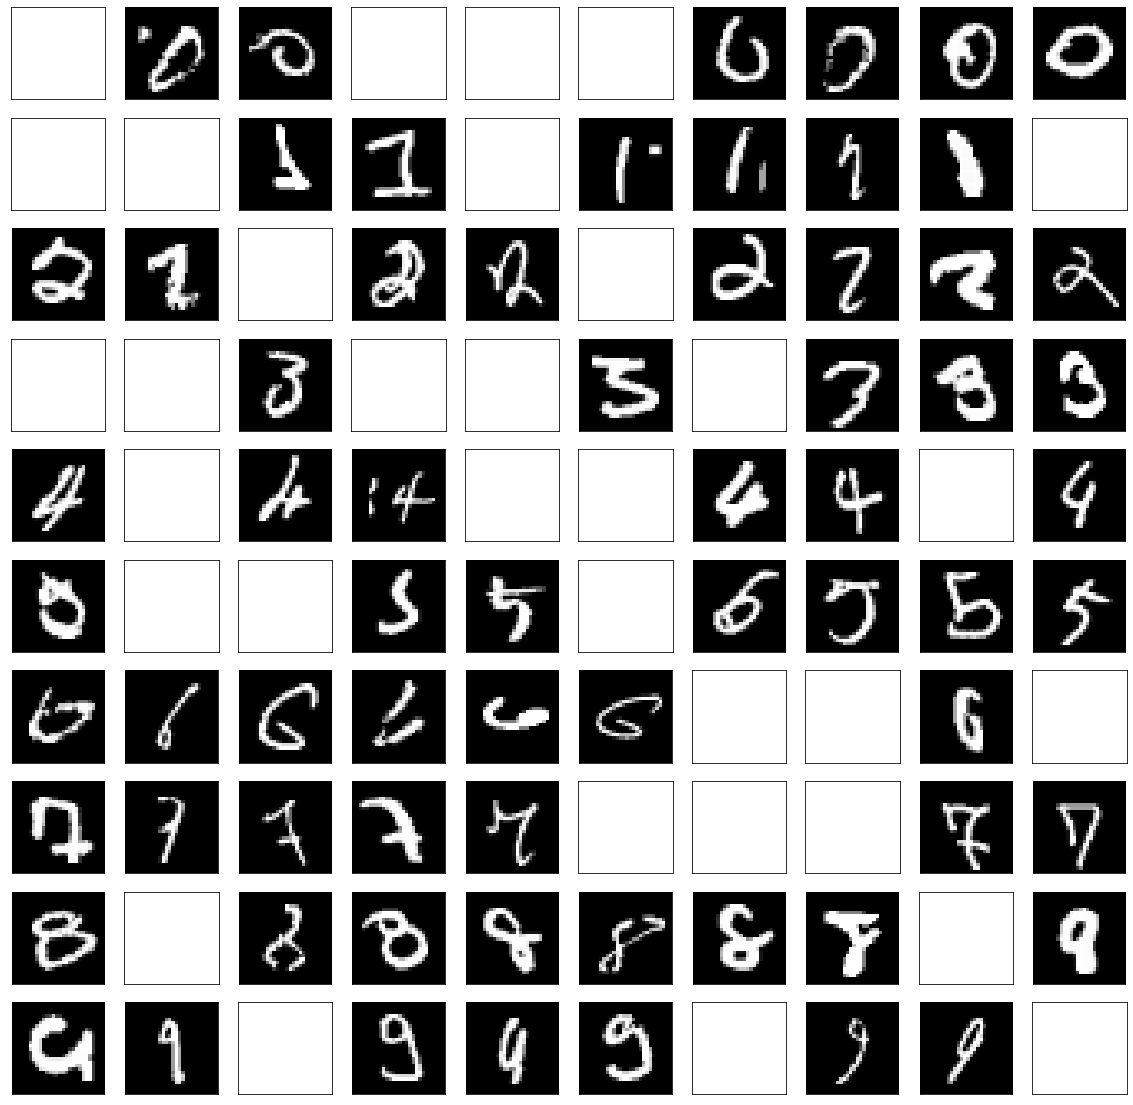

In [17]:
# show the first image in each cell of the error grid
plt.figure(figsize=(20,20))
for y in range(10):
    for x in range(10):
        plt.subplot(10, 10, 1 + (y*10) + x)
        if error_grid[y][x]:
            list_index = error_grid[y][x][0]
            #print("list_index = ",list_index)
            img = X_test[list_index].reshape(28, 28)
            plt.imshow(img, cmap=plt.get_cmap('gray'))
        frame = plt.gca()
        frame.axes.get_xaxis().set_visible(False)
        frame.axes.get_yaxis().set_visible(False)
plt.show()

A “heat map” of our errors, where each cell tells us
how many images fell into that cell. The range runs from black (for no
images at that cell) through reds and then yellows to white.

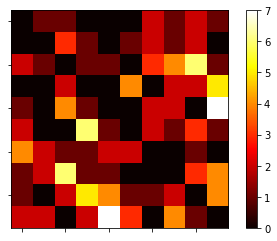

In [18]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

# show a heat map of the length of each error list
gridsize = [[len(error_grid[y][x]) for x in range(10)] for y in range(10)]
fig, ax = plt.subplots()
im = plt.imshow(gridsize, cmap='hot', interpolation='nearest')
ax = plt.gca()
ax.set_yticklabels([])
ax.set_xticklabels([])
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.25)
fig.colorbar(im, cax=cax, orientation='vertical')
plt.show()

The white box in the 9th position of the 5th row shows that on this
training run, the biggest mistake the system consistently made was
with digits that had been labeled as a 4, but which the system identified
as a 9. Out of the 10,000 digits in the validation set, 9 images were
misclassified this way. Other common mistakes were digits labeled as
5 being called 3, and digits labeled 7 being classified as 3.